In [33]:
# imports
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from math import factorial


In [34]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [36]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid') 

The following data was optained with a learning rate of 1e-05
some passed images with their predicted labels:


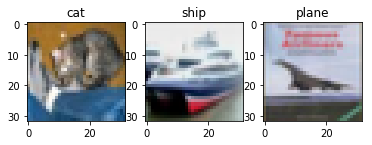

some failed images with their predicted labels:


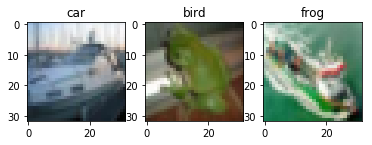

Epoch los history


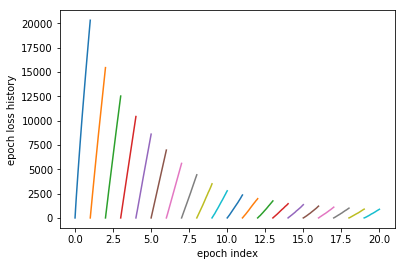

Train los history
In average, the loss becomes smaller with other training cycle


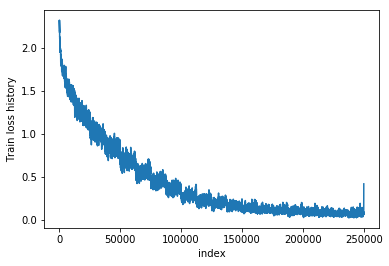

Smoothed test los history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 1.0970909714102746


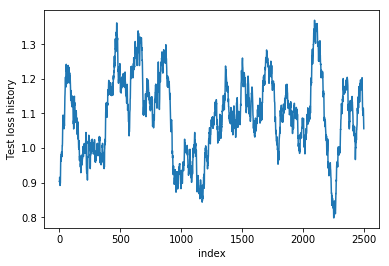

The following data was optained with a learning rate of 0.0001
some passed images with their predicted labels:


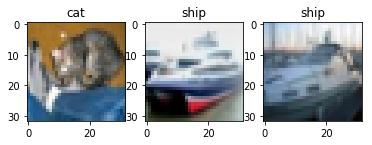

some failed images with their predicted labels:


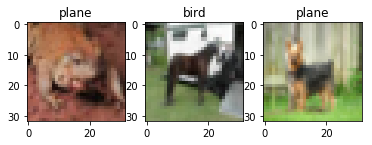

Epoch los history


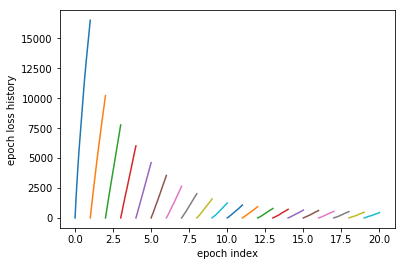

Train los history
In average, the loss becomes smaller with other training cycle


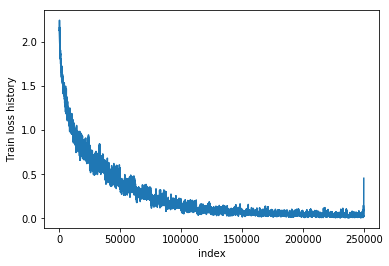

Smoothed test los history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.7283817892067135


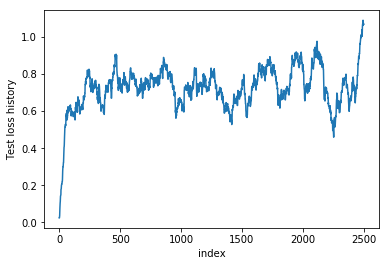

The following data was optained with a learning rate of 0.001
some passed images with their predicted labels:


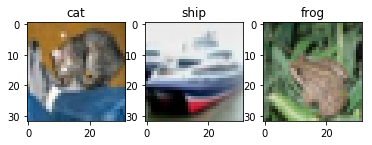

some failed images with their predicted labels:


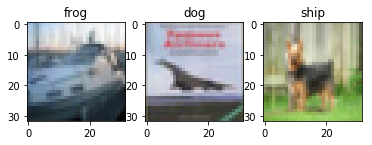

Epoch los history


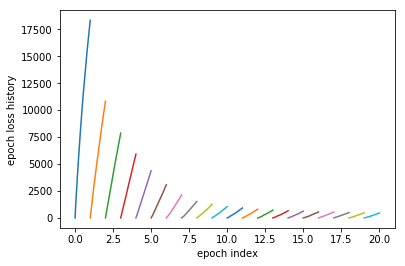

Train los history
In average, the loss becomes smaller with other training cycle


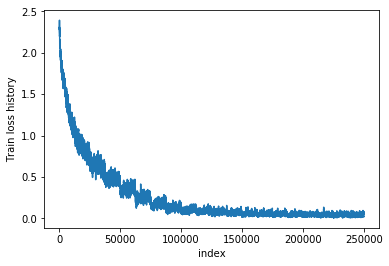

Smoothed test los history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.8896898394628427


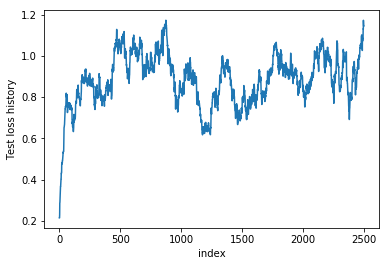

The following data was optained with a learning rate of 0.01
some passed images with their predicted labels:


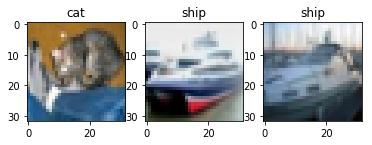

some failed images with their predicted labels:


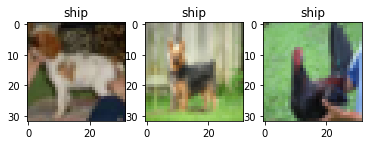

Epoch los history


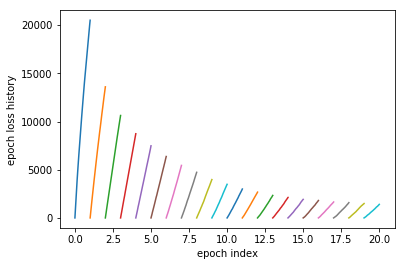

Train los history
In average, the loss becomes smaller with other training cycle


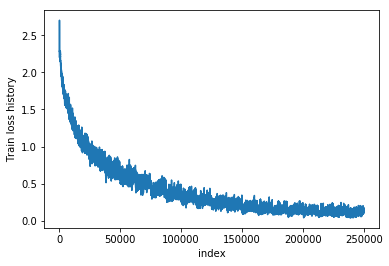

Smoothed test los history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 1.0862021592783975


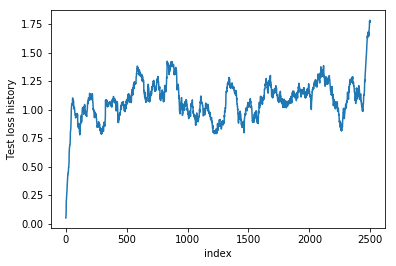

The test with the lowest mean had a learning rate of: 0.0001


In [54]:
learning_rate = 0.00001
mean = []
for k in range(4):
    
    passed_img = np.fromfile('./data/lr_'+str(learning_rate)+'/passed_img_lr'+str(learning_rate)+'.dat', dtype=float)
    passed_lbl = np.fromfile('./data/lr_'+str(learning_rate)+'/passed_lbl_lr'+str(learning_rate)+'.dat', dtype=int)
    failed_img = np.fromfile('./data/lr_'+str(learning_rate)+'/failed_img_lr'+str(learning_rate)+'.dat', dtype=float)
    failed_lbl = np.fromfile('./data/lr_'+str(learning_rate)+'/failed_lbl_lr'+str(learning_rate)+'.dat', dtype=int)
    epoch_loss = np.fromfile('./data/lr_'+str(learning_rate)+'/epoch_loss_history_lr'+str(learning_rate)+'.dat', dtype=float)
    test_loss = np.fromfile('./data/lr_'+str(learning_rate)+'/test_loss_history_lr'+str(learning_rate)+'.dat', dtype=float)
    train_loss = np.fromfile('./data/lr_'+str(learning_rate)+'/train_loss_history_lr'+str(learning_rate)+'.dat', dtype=float)
    
    passed_lbl = np.reshape(passed_lbl, (len(passed_lbl)//10, 10))
    failed_lbl = np.reshape(failed_lbl, (len(failed_lbl)//10, 10))
    passed_img = np.reshape(passed_img, (len(passed_lbl), 3, 32, 32))
    failed_img = np.reshape(failed_img, (len(failed_lbl), 3, 32, 32))

    print('The following data was optained with a learning rate of '+str(learning_rate))
    print("some passed images with their predicted labels:")
    fig1 = plt.figure()
    ax1 = [fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)]

    for i in range(3):
        img = passed_img[i] / 2 + 0.5
        ax1[i].set_title(classes[np.argmax(passed_lbl[i])])
        ax1[i].imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    print("some failed images with their predicted labels:")
    fig2 = plt.figure()
    ax2 = [fig2.add_subplot(131), fig2.add_subplot(132), fig2.add_subplot(133)]

    for i in range(3):
        img = failed_img[i] / 2 + 0.5
        ax2[i].set_title(classes[np.argmax(failed_lbl[i])])
        ax2[i].imshow(np.transpose(img, (1, 2, 0)))
    plt.show()    


    zeros = np.argwhere(epoch_loss==0)

    for i in range(len(zeros)-1):
        y = epoch_loss[zeros[i][0]:zeros[i+1][0]]
        x = np.linspace(i, i+1, len(y))
        plt.plot(x, y)

    print('Epoch los history')
    plt.ylabel('epoch loss history')
    plt.xlabel('epoch index')
    plt.show()
    
    print('Train los history')
    print('In average, the loss becomes smaller with other training cycle')
    plt.plot(savitzky_golay(train_loss, 101, 1))
    plt.ylabel('Train loss history')
    plt.xlabel('index')
    plt.show()
    
    mean.append(np.mean(test_loss))
    print('Smoothed test los history')
    print('Now, there is obviously no more improovement or degradation')
    print('The mean loss of the Test is: '+str(mean[k]))
    plt.plot(savitzky_golay(test_loss, 101, 1))
    plt.ylabel('Test loss history')
    plt.xlabel('index')
    plt.show()
    
    learning_rate = learning_rate * 10
    
print('The test with the lowest mean had a learning rate of: '+str(0.00001*(10**np.argmin(np.array(mean)))))

#import pdb; pdb.set_trace()
